In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import shapely.geometry
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import os

current_palette = sns.color_palette()
cmap = ListedColormap(sns.color_palette(current_palette).as_hex())

sns.set(rc={'figure.figsize':(10,4)}, font_scale=1.0, style='whitegrid', font='CMU Sans Serif')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

def save_fig(ax, folder, suffix, format="pdf"):
    fig = ax.get_figure()
    fig.tight_layout()

    fig.savefig(folder + suffix + "." + format)
    fig.clear()

In [27]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
locations = pd.read_csv("locations.csv")

In [29]:
# we only care about 15 minutes of the experiment
# also we want to offset the start time by another 5 minutes (ramp up)
# convert to milliseconds
experiment_duration = 15 * 60 * 1e3
start_offset = 5 * 60 * 1e3

In [30]:
df_experiment = pd.DataFrame()
all_dfs = []

for run_name in ["cloud", "sat"]:
    for run_number in ["1", "2", "3"]:

        results_dir = os.path.join(".", "results", f"results-{run_name}-{run_number}")
        files = os.listdir(os.path.join(".", results_dir))

        # first we find out the start time of the experiment
        # the actual start time is the latest "first" entry in all of the files
        start_time = 0
        for f in files:
            with open(os.path.join(".", results_dir, f)) as fp:
                # get an iterator
                lines = iter(fp)
                # skip the first line
                next(lines)
                # split the first data line and
                # get send_time_1
                send_time_1 = int(next(lines).split(",")[4])

                if send_time_1 > start_time:
                    start_time = send_time_1

        # convert start_time to milliseconds
        start_time = start_time / 1e6
        start_time += start_offset

        for f in files:

            try:
                client = f[len("cesink"):-len(".ext4-results.csv")]

                df_run = pd.read_csv(os.path.join(".", results_dir, f))
                df_run["client"] = client
                df_run["run_name"] = run_name
                df_run["run_number"] = run_number

                # convert to milliseconds
                df_run["send_time1"] = df_run["send_time1"] / 1e6
                df_run["send_time2"] = df_run["send_time2"] / 1e6
                df_run["recv_time1"] = df_run["recv_time1"] / 1e6
                df_run["recv_time2"] = df_run["recv_time2"] / 1e6

                # now we need to filter out by start_time and duration
                # consider send_time_1 for this
                df_run = df_run[(df_run["send_time1"] >= start_time) & (df_run["send_time1"] <= start_time + experiment_duration)]
                df_run.reset_index(inplace=True)

                df_run["send_latency1"] = df_run["recv_time1"] - df_run["send_time1"]
                df_run["send_latency2"] = df_run["recv_time2"] - df_run["send_time2"]
                df_run["processing_latency"] = df_run["send_time2"] - df_run["recv_time1"]
                df_run["total_latency"] = df_run["recv_time2"] - df_run["send_time1"]

                df_run["latency"] = df_run["recv_time2"] - df_run["send_time1"]

                # print(locations.loc[locations["id"] == client, "lat"].values[0])

                all_dfs.append(df_run)

                df_experiment = df_experiment.append(pd.DataFrame({
                    "client": client,
                    "run_name": run_name,
                    "run_number": run_number,
                    "lat": locations.loc[locations["id"] == client, "lat"].values[0],
                    "lng": locations.loc[locations["id"] == client, "lng"].values[0],
                    "mean_send_latency1": df_run["send_latency1"].mean(),
                    "mean_send_latency2": df_run["send_latency2"].mean(),
                    "mean_processing_latency": df_run["processing_latency"].mean(),
                    "mean_total_latency": df_run["total_latency"].mean(),
                    "median_send_latency1": df_run["send_latency1"].median(),
                    "median_send_latency2": df_run["send_latency2"].median(),
                    "median_processing_latency": df_run["processing_latency"].median(),
                    "median_total_latency": df_run["total_latency"].median(),
                    "max_send_latency1": df_run["send_latency1"].max(),
                    "max_send_latency2": df_run["send_latency2"].max(),
                    "max_processing_latency": df_run["processing_latency"].max(),
                    "max_total_latency": df_run["total_latency"].max(),
                    "99th_send_latency1": df_run["send_latency1"].quantile(0.99),
                    "99th_send_latency2": df_run["send_latency2"].quantile(0.99),
                    "99th_processing_latency": df_run["processing_latency"].quantile(0.99),
                    "99th_total_latency": df_run["total_latency"].quantile(0.99),
                    "95th_send_latency1": df_run["send_latency1"].quantile(0.95),
                    "95th_send_latency2": df_run["send_latency2"].quantile(0.95),
                    "95th_processing_latency": df_run["processing_latency"].quantile(0.95),
                    "95th_total_latency": df_run["total_latency"].quantile(0.95),
                }, index=[0]))

            except Exception as e:
                print(f"Error reading file {f}")
                raise e

df_complete = pd.concat(all_dfs)
df_complete.dropna(inplace=True)
df_complete.reset_index(inplace=True)

df_experiment.dropna(inplace=True)
df_experiment.reset_index(inplace=True)

df_experiment

,index,client,run_name,run_number,lat,lng,mean_send_latency1,mean_send_latency2,mean_processing_latency,mean_total_latency,...,max_processing_latency,max_total_latency,99th_send_latency1,99th_send_latency2,99th_processing_latency,99th_total_latency,95th_send_latency1,95th_send_latency2,95th_processing_latency,95th_total_latency
0,0,S163,cloud,1,34.407370,-131.10420,25.531125,22.117613,1.554447,49.203185,...,28.906982,96.544189,35.734731,26.868521,9.414561,66.573701,34.338281,26.720532,4.946436,61.895557
1,0,S962,cloud,1,31.581560,-160.89450,11.833271,15.311874,3.092053,30.237198,...,55.945801,91.493164,28.272783,25.526587,16.202134,57.653904,27.148621,25.300000,10.004810,46.394287
2,0,S2492,cloud,1,-18.883480,-179.64730,36.845302,34.191890,1.035874,72.073067,...,18.526611,96.649658,51.508779,38.204756,4.722480,90.714502,51.339111,38.032422,1.802295,90.197217
3,0,S1638,cloud,1,21.406030,176.71310,29.580791,26.196677,3.041623,58.819091,...,39.409668,107.230225,46.330410,35.074482,24.703320,95.031895,35.550781,34.846191,9.555225,79.246338
4,0,S2110,cloud,1,1.105467,-85.32836,47.065180,43.525537,1.945824,92.536541,...,48.532471,136.596191,60.063418,49.133125,10.087080,109.454209,58.590137,48.960889,5.276758,105.199072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,0,S1811,sat,3,30.241670,149.90670,6.233680,7.669734,0.860331,14.763745,...,40.961182,70.119385,21.068235,21.205889,1.586389,42.846992,19.985706,20.779089,1.076416,39.800964
1196,0,S497,sat,3,53.031850,-149.03370,8.528415,13.402259,2.176378,24.107051,...,47.773926,78.366211,27.304807,26.537073,15.528501,54.192854,26.547900,25.903809,7.350671,52.333289
1197,0,S731,sat,3,31.108460,-152.27780,7.527177,10.795648,2.536809,20.859634,...,31.518555,66.681152,20.996775,20.914680,16.033691,47.875762,20.522607,20.511853,5.457544,40.408398
1198,0,S134,sat,3,53.088290,-144.21280,7.626091,17.107796,1.056069,25.789956,...,43.800537,77.032227,26.666016,27.264844,3.159863,53.313135,26.308594,26.377686,1.899658,52.230957


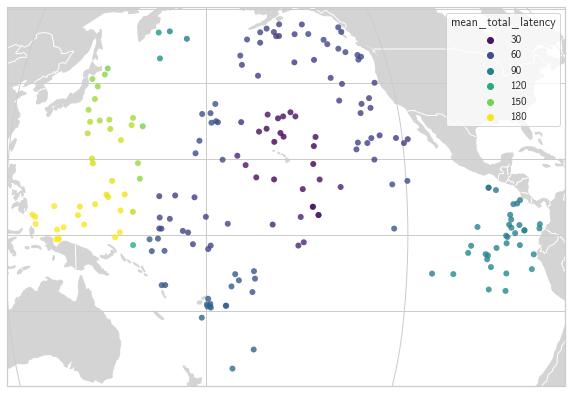

In [31]:
cmap = sns.color_palette("viridis", as_cmap=True)

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': cartopy.crs.Robinson(central_longitude=180)})

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1, edgecolor=("#FFFFFF"))

ax.add_feature(cartopy.feature.LAND, facecolor=("#d4d4d4"))
ax.gridlines()

sns.scatterplot(ax=ax, data=df_experiment[(df_experiment["run_name"] == "cloud") & (df_experiment["run_number"] == "2")], x="lng", y="lat", transform=ccrs.PlateCarree(), palette=cmap, zorder=10, linewidth=0, alpha=0.8, hue="mean_total_latency")

plt.show()

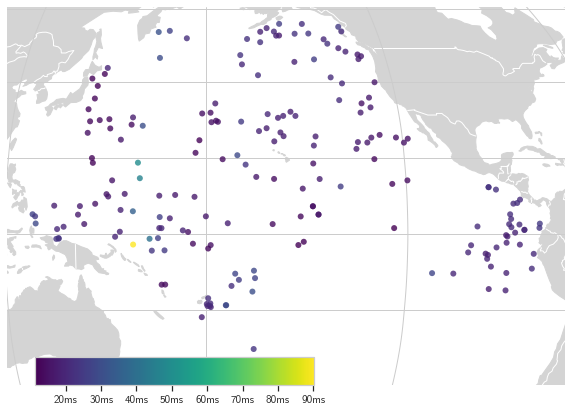

In [32]:
cmap = sns.color_palette("viridis", as_cmap=True)
df = df_experiment[(df_experiment["run_name"] == "sat") & (df_experiment["run_number"] == "1")]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': cartopy.crs.Robinson(central_longitude=180)})

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1, edgecolor=("#FFFFFF"))

ax.add_feature(cartopy.feature.LAND, facecolor=("#d4d4d4"))
ax.gridlines()

sns.scatterplot(ax=ax, data=df, x="lng", y="lat", transform=ccrs.PlateCarree(), palette=cmap, zorder=10, linewidth=0, alpha=0.8, hue="mean_total_latency")

norm = plt.Normalize(max(df["mean_total_latency"]), min(df["mean_total_latency"]))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
ax.get_legend().remove()
cbar = ax.figure.colorbar(sm, location='bottom', shrink=0.5, pad=-0.15, aspect=10, anchor=(0.1, 0))
cbar.ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%dms'))
ax.axis('off')

plt.show()

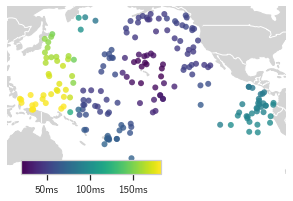

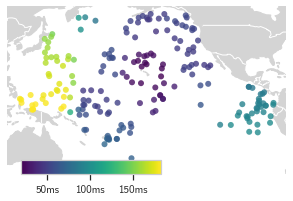

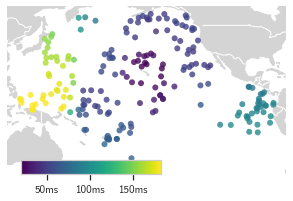

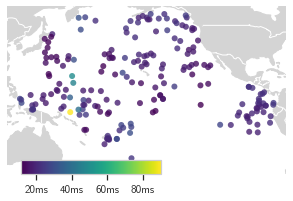

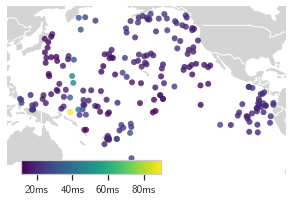

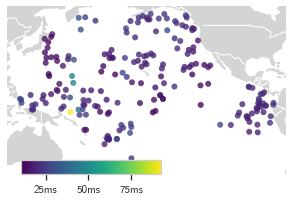

In [33]:
cmap = sns.color_palette("viridis", as_cmap=True)

def make_map(df, name):
    fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1, edgecolor=("#FFFFFF"))
    ax.add_feature(cartopy.feature.LAND, facecolor=("#d4d4d4"))
    # ax.set_extent ((-7.5, 40, 33, 59), cartopy.crs.PlateCarree())
    sns.scatterplot(ax=ax, data=df, x="lng", y="lat",hue="mean_total_latency", palette=cmap, transform=ccrs.Geodetic(), zorder=10, linewidth=0, alpha=0.8)

    norm = plt.Normalize(max(df["mean_total_latency"]), min(df["mean_total_latency"]))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    ax.get_legend().remove()
    cbar = ax.figure.colorbar(sm, location='bottom', shrink=0.5, pad=-0.15, aspect=10, anchor=(0.1, 0))
    cbar.ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%dms'))
    ax.axis('off')
    plt.show()
    #save_fig(ax=ax, folder="", suffix=name, format="pdf")f
for name in ["cloud", "sat"]:
    for run in ["1", "2", "3"]:
        make_map(df_experiment[ (df_experiment["run_name"] == name) &(df_experiment["run_number"] == run)], f"{name}_{run}")

         level_0  index  sensor_id      service_id  packet_n  packet_len  \
5372481        0   2365      111.0  13.0.celestial     474.0        77.0   
5372482        1   2366      112.0  13.0.celestial     472.0        77.0   
5372483        2   2367      101.0  13.0.celestial     473.0        77.0   
5372484        3   2368      106.0  13.0.celestial     473.0        77.0   
5372485        4   2369      110.0  13.0.celestial     474.0        77.0   

           send_time1    recv_time1    send_time2    recv_time2 client  \
5372481  1.646563e+12  1.646563e+12  1.646563e+12  1.646563e+12   S962   
5372482  1.646563e+12  1.646563e+12  1.646563e+12  1.646563e+12   S962   
5372483  1.646563e+12  1.646563e+12  1.646563e+12  1.646563e+12   S962   
5372484  1.646563e+12  1.646563e+12  1.646563e+12  1.646563e+12   S962   
5372485  1.646563e+12  1.646563e+12  1.646563e+12  1.646563e+12   S962   

        run_name run_number  send_latency1  send_latency2  processing_latency  \
5372481      sat 

<AxesSubplot:xlabel='send_latency2', ylabel='Proportion'>

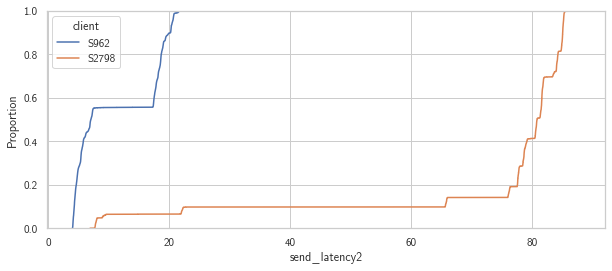

In [34]:
slow_client_df = df_complete[(df_complete["run_name"] == "sat") & (df_complete["run_number"] == "2") & ((df_complete["client"] == "S2798") | (df_complete["client"] == "S962"))]

print(slow_client_df.head())
sns.ecdfplot(data=slow_client_df, x="send_latency2", hue="client")

<AxesSubplot:xlabel='send_latency2', ylabel='Proportion'>

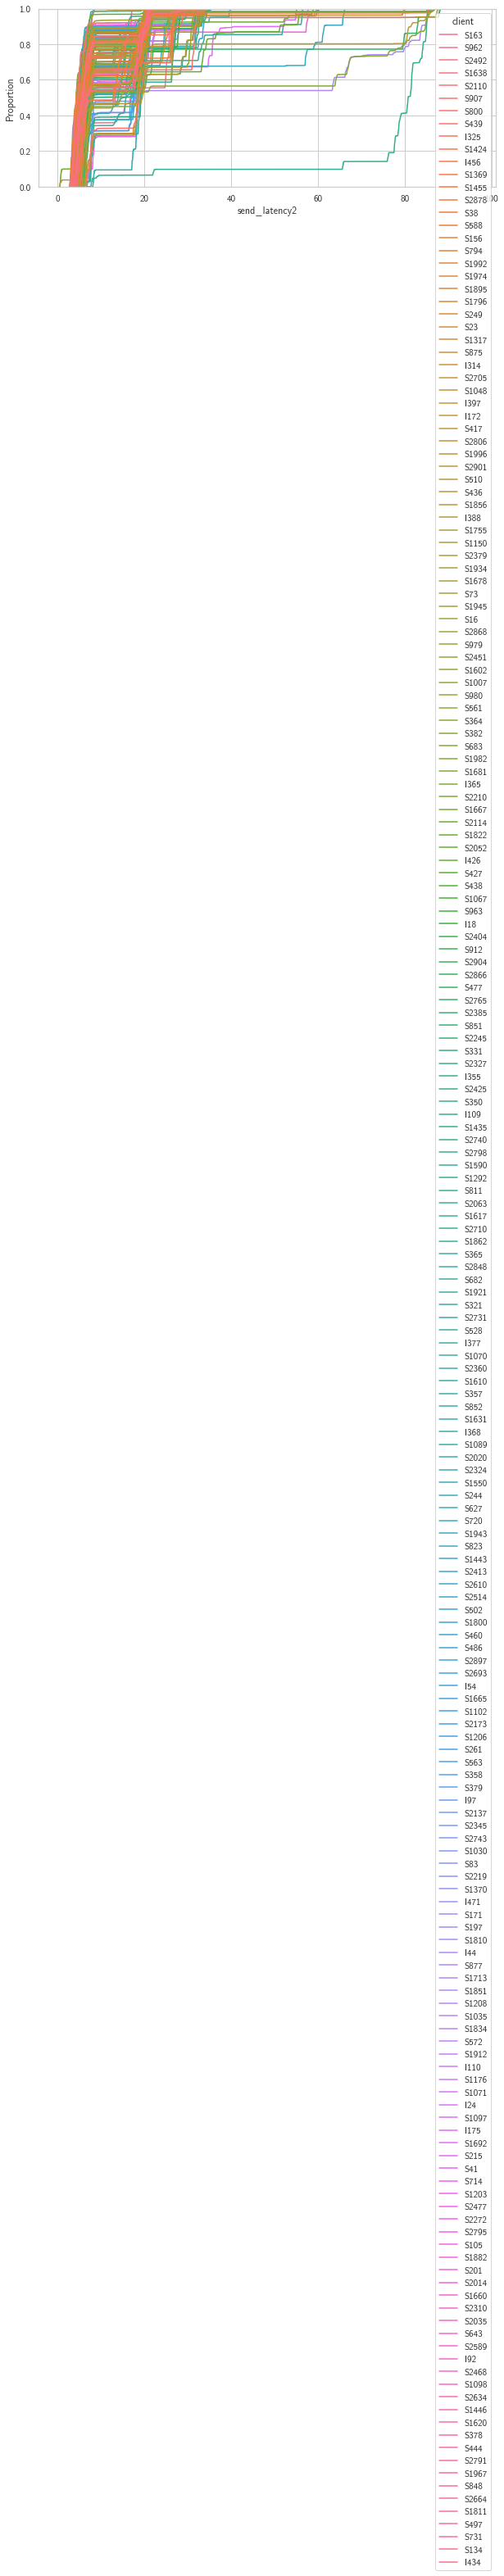

In [35]:
sns.ecdfplot(data=df_complete[(df_complete["run_name"] == "sat") & (df_complete["run_number"] == "2")], x="send_latency2", hue="client")

In [36]:
test_df_cloud = df_complete[(df_complete["run_name"] == "cloud") & (df_complete["run_number"] == "2")]
test_df_sat = df_complete[(df_complete["run_name"] == "sat") & (df_complete["run_number"] == "2")]

In [37]:
test_df_cloud

,level_0,index,sensor_id,service_id,packet_n,packet_len,send_time1,recv_time1,send_time2,recv_time2,client,run_name,run_number,send_latency1,send_latency2,processing_latency,total_latency,latency
1337046,0,6849,37.0,hawaii.gst.celestial,485.0,82.0,1.646569e+12,1.646569e+12,1.646569e+12,1.646569e+12,S163,cloud,2,21.871826,19.650879,1.843994,43.366699,43.366699
1337047,1,6850,44.0,hawaii.gst.celestial,490.0,82.0,1.646569e+12,1.646569e+12,1.646569e+12,1.646569e+12,S163,cloud,2,22.899902,19.726807,1.262451,43.889160,43.889160
1337048,2,6851,55.0,hawaii.gst.celestial,487.0,82.0,1.646569e+12,1.646569e+12,1.646569e+12,1.646569e+12,S163,cloud,2,18.419678,19.746826,0.526611,38.693115,38.693115
1337049,3,6852,89.0,hawaii.gst.celestial,493.0,82.0,1.646569e+12,1.646569e+12,1.646569e+12,1.646569e+12,S163,cloud,2,18.595947,20.335449,1.753662,40.685059,40.685059
1337050,4,6853,46.0,hawaii.gst.celestial,485.0,82.0,1.646569e+12,1.646569e+12,1.646569e+12,1.646569e+12,S163,cloud,2,20.714600,19.680420,0.963379,41.358398,41.358398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2674379,7020,9430,137.0,hawaii.gst.celestial,1895.0,83.0,1.646570e+12,1.646570e+12,1.646570e+12,1.646570e+12,I434,cloud,2,87.980713,74.135742,1.992188,164.108643,164.108643
2674380,7021,9431,188.0,hawaii.gst.celestial,1887.0,83.0,1.646570e+12,1.646570e+12,1.646570e+12,1.646570e+12,I434,cloud,2,87.753418,74.170898,0.607910,162.532227,162.532227
2674381,7022,9432,173.0,hawaii.gst.celestial,1889.0,83.0,1.646570e+12,1.646570e+12,1.646570e+12,1.646570e+12,I434,cloud,2,87.746338,74.476807,0.928223,163.151367,163.151367
2674382,7023,9433,138.0,hawaii.gst.celestial,1892.0,83.0,1.646570e+12,1.646570e+12,1.646570e+12,1.646570e+12,I434,cloud,2,88.653809,74.158691,2.739990,165.552490,165.552490


<AxesSubplot:xlabel='processing_latency', ylabel='Count'>

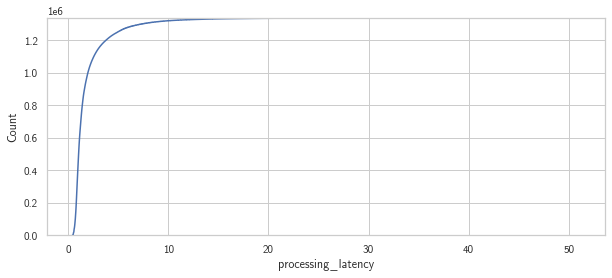

In [38]:
sns.ecdfplot(data=test_df_cloud, x="processing_latency", stat="count")

<AxesSubplot:xlabel='processing_latency', ylabel='Proportion'>

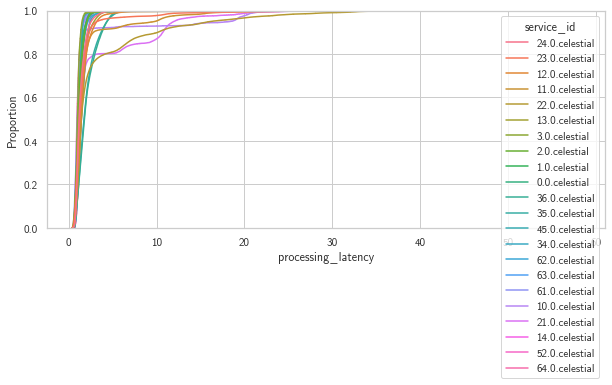

In [39]:
sns.ecdfplot(data=test_df_sat, x="processing_latency", hue="service_id")

<AxesSubplot:xlabel='sensor_id', ylabel='count'>

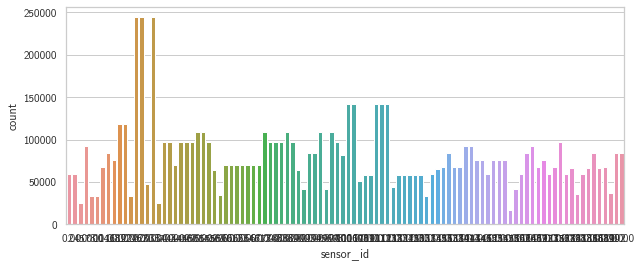

In [40]:
sns.countplot(data=df_complete, x="sensor_id")

In [43]:
df_paper = df_experiment[df_experiment["run_number"] == "2"]
print(min(df_paper[df_paper["run_name"] == "cloud"]["mean_total_latency"]))
print(max(df_paper[df_paper["run_name"] == "cloud"]["mean_total_latency"]))
print(min(df_paper[df_paper["run_name"] == "sat"]["mean_total_latency"]))
print(max(df_paper[df_paper["run_name"] == "sat"]["mean_total_latency"]))

21.703346541293094
182.88805561120014
12.530056822817766
89.6012553693561


<AxesSubplot:xlabel='mean_total_latency', ylabel='Proportion'>

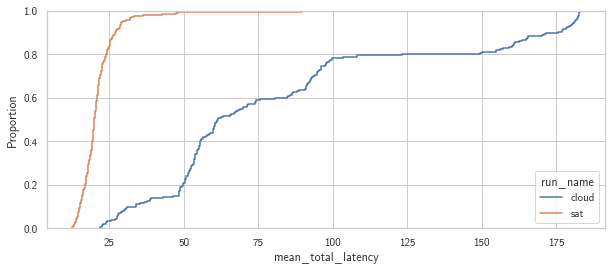

In [45]:
sns.ecdfplot(df_paper, x="mean_total_latency", hue="run_name")

<AxesSubplot:xlabel='mean_processing_latency', ylabel='Proportion'>

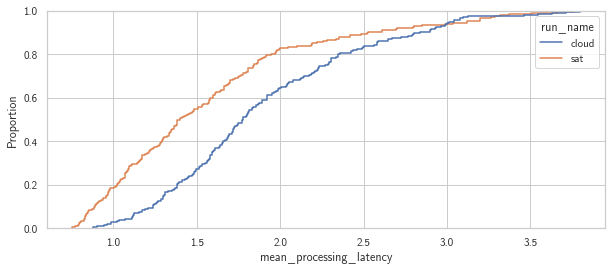

In [50]:
sns.ecdfplot(df_paper, x="mean_processing_latency", hue="run_name")

In [51]:
print(df_paper[df_paper["run_name"] == "cloud"]["mean_processing_latency"].mean())
print(df_paper[df_paper["run_name"] == "sat"]["mean_processing_latency"].mean())

1.9040615293058902
1.5722153758278077
